In [1]:
import numpy as np
import pandas as pd
import math
from math import sin, cos, radians, atan2
import matplotlib.pyplot as plt

# Accuracy 

3 mm accuracy in x and y 

2 deg accuracy for yaw

In [2]:
FOLDER_NAME = 'erl-polimi-test'
FILE_NAME = 'log_work_mocap_2017-11-20-15-22-23_0/_slash_work_slash_robot_slash_pose.csv'
READINGS_PER_SEC = 100
ACCURACY_IN_DISTANCE = 4   #mm
ACCURACY_IN_ANGLE = 3      #degres
#The starting point from where the robot starts
STARTING_POINT = 3000

In [3]:
FOLDER_NAME + '/' + FILE_NAME

'erl-polimi-test/log_work_mocap_2017-11-20-15-22-23_0/_slash_work_slash_robot_slash_pose.csv'

In [4]:
def Quaternion_toEulerianAngle(row):
    
    x = row['x.1']
    y = row['y.1']
    z = row['z.1']
    w = row['w']
    ysqr = y*y

    t0 = +2.0 * (w * x + y*z)
    t1 = +1.0 - 2.0 * (x*x + ysqr)
    X = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w*y - z*x)
    t2 =  1 if t2 > 1 else t2
    t2 = -1 if t2 < -1 else t2
    Y = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x*y)
    t4 = +1.0 - 2.0 * (ysqr + z*z)
    Z = math.degrees(math.atan2(t3, t4))


    return Z 

In [5]:
data = pd.read_csv(FOLDER_NAME + '/' + FILE_NAME)
data.secs = pd.to_datetime(data.secs, unit='s')
data['yaw'] = data.apply(Quaternion_toEulerianAngle, axis=1)
data.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w,yaw
0,1511187743489721037,NaN,51,NaN,2017-11-20 14:22:23,489457956,world,NaN,NaN,-0.419728,-1.312920,0.098631,NaN,-0.003047,0.011698,-0.998610,-0.051299,174.123393
1,1511187743498054329,NaN,52,NaN,2017-11-20 14:22:23,497707010,world,NaN,NaN,-0.419719,-1.312910,0.098639,NaN,-0.003160,0.012158,-0.998608,-0.051235,174.131001
2,1511187743506336565,NaN,53,NaN,2017-11-20 14:22:23,506088212,world,NaN,NaN,-0.419745,-1.312945,0.098652,NaN,-0.003633,0.010814,-0.998613,-0.051407,174.111273
3,1511187743514391117,NaN,54,NaN,2017-11-20 14:22:23,514188897,world,NaN,NaN,-0.419741,-1.312936,0.098652,NaN,-0.003637,0.011212,-0.998612,-0.051336,174.119599
4,1511187743522959819,NaN,55,NaN,2017-11-20 14:22:23,522715196,world,NaN,NaN,-0.419756,-1.312965,0.098634,NaN,-0.004468,0.008922,-0.998632,-0.051332,174.119837


In [11]:
%matplotlib qt
waypoints = pd.read_csv("erl_waypoints.csv")
f, ax = plt.subplots(figsize=(25,15))
plt.scatter(waypoints.x, waypoints.y)

for idx, row in waypoints.iterrows():
    ax.annotate(row.location,
            xy=(row.x, row.y), xycoords='data',
            xytext=(-20, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
# PLotting the path
ax.plot(data.x, data.y)
ax.set_xlim([-4, 4])
ax.set_ylim([-3, 3])
ax.axis('equal')
plt.savefig(FOLDER_NAME +  '/' + FOLDER_NAME + '_trajectory.png')
#ax.xlim([-4, 4])
#ax.ylim([3, -3])
#ax.xlabel('meter')

In [6]:

def angle_plateau_detection(yaw):
    #Rounding off to the accuracy of the value. 
    yaw_round = yaw.round(0)  
    unique_values = np.unique(yaw_round)
    if(len(unique_values) > ACCURACY_IN_ANGLE):
        return 0
    else:
        return 1
    
def plateau_detection(x):
    x_round = x.round(3)
    unique_values = np.unique(x_round)
    if(len(unique_values) > ACCURACY_IN_DISTANCE):
        return 0
    else:
        return 1
    
change_detection_x = pd.rolling_apply(data.x, 3*READINGS_PER_SEC, plateau_detection)
change_detection_x.fillna(1)
change_detection_y = pd.rolling_apply(data.y, 3*READINGS_PER_SEC, plateau_detection)
change_detection_y.fillna(1)
change_detection_yaw = pd.rolling_apply(data.yaw, 3*READINGS_PER_SEC, angle_plateau_detection)
change_detection_yaw.fillna(1)
change_detection = change_detection_x * change_detection_y * change_detection_yaw
data['robot_still'] = change_detection
still_points = data[data['robot_still'] == 1]


/home/deebuls/anaconda3/envs/erl/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
/home/deebuls/anaconda3/envs/erl/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
/home/deebuls/anaconda3/envs/erl/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)


In [7]:
waypoints = pd.read_csv("erl_waypoints.csv")
directions = pd.read_csv("erl_directions.csv")

def nearest_location(row):
    nearest_waypoint = ''
    minimum_distance = 1000 #some large value
    for idx, wp in waypoints.iterrows():
        distance = math.sqrt((wp.x - row.x)**2 + (wp.y - row.y)**2)
        
        if distance < minimum_distance:
            nearest_waypoint = wp.location
            minimum_distance = distance
            
    nearest_angle = ''
    minimum_angle = 1000 #some large value
    for idx, direction in directions.iterrows():
        
        angle = atan2(sin(radians(row.yaw) - radians(direction.angle)), cos(radians(row.yaw) - radians(direction.angle)))
        if abs(angle) < minimum_angle:
            nearest_angle = direction.direction
            minimum_angle = abs(angle)
    return pd.Series({"minimum_distance": minimum_distance, "nearest_location": nearest_waypoint,
                      "minimum_angle": minimum_angle, "nearest_angle":nearest_angle})

    #return nearest_waypoint, distance


data[[ "minimum_angle", "minimum_distance", "nearest_angle", "nearest_location" ]] = data[data['robot_still'] == 1].apply(nearest_location, axis=1)
still_data = data[data['robot_still'] == 1]
still_data.head()

#Finding the points of change
data['diff_change_point'] = data['robot_still'].diff()
data[data['diff_change_point'] == -1]

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,...,y.1,z.1,w,yaw,robot_still,minimum_angle,minimum_distance,nearest_angle,nearest_location,diff_change_point
1659,1511187757314585923,NaN,1710,NaN,2017-11-20 14:22:37,314288017,world,NaN,NaN,-0.420301,...,-0.003600,-0.998574,-0.053193,173.900595,0.0,NaN,NaN,NaN,NaN,-1.0
2738,1511187766305971593,NaN,2789,NaN,2017-11-20 14:22:46,305691806,world,NaN,NaN,-1.985766,...,0.022250,-0.998503,-0.045226,174.867466,0.0,NaN,NaN,NaN,NaN,-1.0
3860,1511187775656284811,NaN,3911,NaN,2017-11-20 14:22:55,655912645,world,NaN,NaN,-2.158490,...,0.022621,-0.619888,-0.784337,76.663375,0.0,NaN,NaN,NaN,NaN,-1.0
5016,1511187785289605672,NaN,5067,NaN,2017-11-20 14:23:05,289337121,world,NaN,NaN,-2.350698,...,0.021784,-0.640829,-0.767373,79.756193,0.0,NaN,NaN,NaN,NaN,-1.0
6483,1511187797514433230,NaN,6534,NaN,2017-11-20 14:23:17,514136124,world,NaN,NaN,-1.724248,...,-0.000688,-0.304012,-0.952643,35.396344,0.0,NaN,NaN,NaN,NaN,-1.0
7493,1511187805931206277,NaN,7544,NaN,2017-11-20 14:23:25,930930023,world,NaN,NaN,-0.302729,...,0.016910,0.075299,-0.996921,-8.666260,0.0,NaN,NaN,NaN,NaN,-1.0
8540,1511187814656191126,NaN,8591,NaN,2017-11-20 14:23:34,656010008,world,NaN,NaN,-0.332345,...,0.008024,0.721271,-0.692575,-92.326982,0.0,NaN,NaN,NaN,NaN,-1.0
9543,1511187823014603796,NaN,9594,NaN,2017-11-20 14:23:43,14338790,world,NaN,NaN,0.277734,...,-0.007254,0.688862,-0.724733,-87.084962,0.0,NaN,NaN,NaN,NaN,-1.0


In [8]:
%matplotlib 
normalized_x=(data.x -data.x.min())/(data.x.max()-data.x.min())
normalized_y=(data.y -data.y.min())/(data.y.max()-data.y.min())
normalized_yaw=(data.yaw -data.yaw.min())/(data.yaw.max()-data.yaw.min())

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True, figsize=(25,12))
axarr[0].plot(normalized_x)
axarr[0].plot(change_detection_x)
axarr[0].set_ylabel('x_norm')
axarr[0].set_title('Robot Pose recorded over time')
axarr[0].fill_between(np.arange(0,change_detection.size), 0, change_detection_x, facecolor='green', alpha=0.5 )


axarr[1].plot(normalized_y)
axarr[1].plot(change_detection_y)
axarr[1].set_ylabel('y_norm')
axarr[1].fill_between(np.arange(0,change_detection.size), 0, change_detection_y, facecolor='green', alpha=0.5 )


axarr[2].plot(normalized_yaw)
axarr[2].plot(change_detection_yaw)
axarr[2].set_ylabel('yaw_norm')
axarr[2].fill_between(np.arange(0,change_detection.size), 0, change_detection_yaw, facecolor='green', alpha=0.5 )


axarr[3].plot(change_detection)
axarr[3].set_title('3 secs stable robot')

axarr[3].fill_between(np.arange(0,change_detection.size), 0, change_detection, facecolor='green', alpha=0.5 )

#axarr[1].plot(change_detection_y)
for idx,row in data[data['diff_change_point'] == 1].iterrows():
    axarr[3].axvline(row.name, linewidth=2, color='r')
    annotate_label = row.nearest_location + ',' + row.nearest_angle
    axarr[3].annotate(annotate_label,
            xy=(row.name, 0), xycoords='data',
            xytext=(-20, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
print ('')
for idx,row in data[data['diff_change_point'] == -1].iterrows():
    print (row.name)
    axarr[3].axvline(row.name, linewidth=2, color='y')
plt.savefig(FOLDER_NAME + '/' + FOLDER_NAME + '_changepoint.png')
plt.show()


Using matplotlib backend: Qt4Agg

1659
2738
3860
5016
6483
7493
8540
9543


In [10]:


print ("Waypoint, direction, minimum_distance(meter),minimum_angle(deg)")
results = pd.DataFrame(columns=('Waypoint', 'Direction', 'minimum_distance(meter)', 'minimum_angle(deg)'))

N = 0
average_min_distance = 0
average_min_angle = 0
#Loop on starting points
for idx,row in data[data['diff_change_point'] == 1].iterrows():
    #dont count until the starting point
    if row.name < STARTING_POINT:
        continue
    #loop on ending points   
    for idx1, internal_row in data[data['diff_change_point'] == -1].iterrows():
        #Finding the next lowering column
        if internal_row.name > row.name:
            #Finding the minimum distance and the minimum angle
            #print (row.name, internal_row.name)
            robot_stable_data = data.iloc[row.name:internal_row.name]
            
            minimum_error_distance = 1000
            minimum_error_angle = 1000

            for i in range(row.name, internal_row.name):
                average_error_distance_per_3secs = data.iloc[i:i+3*READINGS_PER_SEC]['minimum_distance'].mean()
                if average_error_distance_per_3secs < minimum_error_distance :
                    minimum_error_distance = average_error_distance_per_3secs
                    
                average_error_angle_per_3secs = data.iloc[i:i+3*READINGS_PER_SEC]['minimum_angle'].mean()
                if average_error_angle_per_3secs < minimum_error_angle :
                    minimum_error_angle = average_error_angle_per_3secs
                    
            print ('{}, {}, {:.4f}, {:.2f}'.format(data.iloc[row.name].nearest_location, 
                                           data.iloc[row.name].nearest_angle, 
                                           minimum_error_distance,
                                           math.degrees(minimum_error_angle)))
            N = N +1
            average_min_distance = average_min_distance + minimum_error_distance
            average_min_angle = average_min_angle + math.degrees(minimum_error_angle)
                                
            results.loc[N] = [data.iloc[row.name].nearest_location, 
                              data.iloc[row.name].nearest_angle,
                              minimum_error_distance, 
                              math.degrees(minimum_error_angle)]
            break
            
print ('Average Min Distance Error: {:.4f} meter'.format(average_min_distance/N))
print ('Average Min Angle Error: {:.2f} deg'.format( average_min_angle/N))

#Rounding off
results['minimum_distance(meter)'] = results['minimum_distance(meter)'].round(4)
results['minimum_angle(deg)'] = results['minimum_angle(deg)'].round(2)
results.to_csv(FOLDER_NAME +  '/' + FOLDER_NAME + '_results.csv' )


Waypoint, direction, minimum_distance(meter),minimum_angle(deg)
WP03, W, 0.6874, 9.81
WP01, W, 0.2295, 7.22
WP01, N, 1.4185, 35.88
WP08, N, 1.9323, 6.48
WP08, E, 1.0031, 2.50
WP05, E, 0.3644, 1.62
Average Min Distance Error: 0.9392 meter
Average Min Angle Error: 10.59 deg


In [64]:
9950 + 300

10250

In [58]:
from sklearn.cluster import KMeans

X = still_data[['x','y']].as_matrix()
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)

y_pred = KMeans(n_clusters=11, random_state=0 ).fit_predict(X)

kmeans.cluster_centers_

array([[ 1.57094123, -0.82453443],
       [-2.59706418,  0.85309413],
       [ 2.55363984,  1.60674265],
       [ 0.21724905,  0.35491408],
       [ 1.80235826,  1.02759203],
       [-2.35309293,  1.88419082],
       [-1.20802404, -0.94873679],
       [ 1.87813833,  0.16473982],
       [-2.60275279, -0.51507387],
       [ 0.38802294,  1.28307072],
       [ 0.0044615 , -0.00686837]])

In [59]:
# PLotting the path
ax = plt.subplot()
plt.scatter(still_data.x, still_data.y, c=y_pred)
plt.xlim([-4, 4])
plt.ylim([-3, 3])
plt.xlabel('meter')


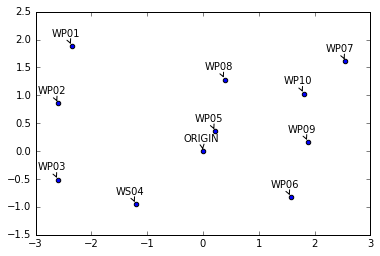

In [4]:
waypoints = pd.read_csv("erl_waypoints.csv")
ax = plt.subplot()
plt.scatter(waypoints.x, waypoints.y)

for idx, row in waypoints.iterrows():
    ax.annotate(row.location,
            xy=(row.x, row.y), xycoords='data',
            xytext=(-20, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
plt.show()

In [20]:
READINGS_PER_SEC = 100
x_nearby = data.yaw.round(0) 
#forT 
START = 0
x_nearby[START:START + 3*READINGS_PER_SEC].unique()

array([ 37.,  36.])

In [65]:
robot_stable_data = data.iloc[9950:10191]
robot_stable_data
for i in range(9950, 10191):
    #looking in the 3 sec window
    print (i, i + 3*READINGS_PER_SEC)
    print (data.iloc[i:i+3*READINGS_PER_SEC]['minimum_distance'].mean() )

9950 10250
0.0153157633114
9951 10251
0.0153160406876
9952 10252
0.0153161771599
9953 10253
0.0153164181786
9954 10254
0.0153166567178
9955 10255
0.0153169089709
9956 10256
0.0153170955745
9957 10257
0.015317311705
9958 10258
0.0153176226442
9959 10259
0.0153178389403
9960 10260
0.0153181226205
9961 10261
0.0153182964243
9962 10262
0.0153185238979
9963 10263
0.0153187969718
9964 10264
0.0153191415359
9965 10265
0.0153195053889
9966 10266
0.0153197558912
9967 10267
0.0153199692195
9968 10268
0.0153202631999
9969 10269
0.0153206347736
9970 10270
0.0153207976942
9971 10271
0.0153209858736
9972 10272
0.0153211498777
9973 10273
0.0153213669796
9974 10274
0.015321547195
9975 10275
0.0153218301165
9976 10276
0.0153220491608
9977 10277
0.015322215143
9978 10278
0.0153225847062
9979 10279
0.0153228829509
9980 10280
0.0153232080132
9981 10281
0.0153234082159
9982 10282
0.0153235659623
9983 10283
0.0153199371127
9984 10284
0.0153201167999
9985 10285
0.0153201987006
9986 10286
0.0153203799961
9987

In [27]:
math.radians(180) -0.0835

3.058092653589793

In [62]:
way_name, way_x, way_y = np.loadtxt('./erl_waypoints.csv', skiprows=1, delimiter=',', dtype=('str'), unpack=True)
way_x = way_x.astype('float')
way_y = way_y.astype('float')
for a,b,c in zip(way_name, way_x, way_y):
    print (a,b,c)

WP06 1.57094123 -0.82453443
WP02 -2.59706418 0.85309413
WP07 2.55363984 1.60674265
WP05 0.21724905 0.35491408
WP10 1.80235826 1.02759203
WP01 -2.35309293 1.88419082
WS04 -1.20802404 -0.94873679
WP09 1.87813833 0.16473982
WP03 -2.60275279 -0.51507387
WP08 0.38802294 1.28307072
ORIGIN 0.0044615 -0.00686837


In [86]:
directions = pd.read_csv("erl_directions.csv")
row = data.loc[[19125]]
print (row.yaw)
nearest_angle = ''
minimum_angle = 1000 #some large value
for idx, direction in directions.iterrows():
    angle = atan2(sin(radians(row.yaw) - radians(direction.angle)), cos(radians(row.yaw) - radians(direction.angle)))
    if abs(angle) < minimum_angle:
        nearest_angle = direction.direction
        minimum_angle = angle
    print (direction.angle,'min',angle)
    
print (minimum_angle, nearest_angle)

19125   -92.710792
Name: yaw, dtype: float64
0 min -1.6181085703253217
90 min 3.0942804100593686
-90 min -0.04731224353042518
180 min 1.5234840832644718
-1.6181085703253217 N
